# Classifier Comparison

In [1]:
# Source:
#   https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html

# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# Modified to integrate Concrete ML functions by Zama
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from skorch.classifier import NeuralNetClassifier

from concrete.ml.sklearn import DecisionTreeClassifier as ConcreteDecisionTreeClassifier
from concrete.ml.sklearn import LinearSVC as ConcreteLinearSVC
from concrete.ml.sklearn import LogisticRegression as ConcreteLogisticRegression
from concrete.ml.sklearn import NeuralNetClassifier as ConcreteNeuralNetClassifier
from concrete.ml.sklearn import RandomForestClassifier as ConcreteRandomForestClassifier
from concrete.ml.sklearn import XGBClassifier as ConcreteXGBClassifier

%matplotlib inline

In [2]:
params_neural_net = {
    "module__n_layers": 3,
    "module__n_w_bits": 2,
    "module__n_a_bits": 2,
    "module__n_accum_bits": 7,
    "module__n_hidden_neurons_multiplier": 1,
    "module__n_outputs": 2,
    "module__input_dim": 2,
    "max_epochs": 200,
    "verbose": 0,
    "lr": 0.001,
}


class FC(torch.nn.Module):
    def __init__(self, activation_function):
        super().__init__()
        self.fc1 = torch.nn.Linear(in_features=2, out_features=8)
        self.fc2 = torch.nn.Linear(in_features=8, out_features=8)
        self.fc3 = torch.nn.Linear(in_features=8, out_features=8)
        self.fc4 = torch.nn.Linear(in_features=8, out_features=2)
        self.act = activation_function()

    def forward(self, x):
        """Forward pass."""
        out = self.fc1(x.to(torch.float32))
        out = self.act(out)
        out = self.fc2(out)
        out = self.act(out)
        out = self.fc3(out)
        out = self.act(out)
        out = self.fc4(out)

        return out


classifier_list = [
    # Clear classifiers
    (SVC(kernel="linear", C=0.025), "Linear SVC"),
    (LogisticRegression(), "Logistic Regression"),
    (DecisionTreeClassifier(max_depth=5), "Decision Tree"),
    (RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1), "Random Forest"),
    (MLPClassifier(alpha=1, max_iter=1000), "MLP"),
    (NeuralNetClassifier(FC(torch.nn.ReLU), verbose=0), "Neural Net"),
    # FHE classifiers
    (ConcreteLinearSVC(C=0.025), "Concrete Linear SVC"),
    (ConcreteLogisticRegression(), "Concrete Logistic Regression"),
    (ConcreteDecisionTreeClassifier(max_depth=5), "Concrete Decision Tree"),
    (ConcreteNeuralNetClassifier(**params_neural_net), "Concrete Neural Net"),
    (ConcreteXGBClassifier(n_jobs=1), "Concrete XGB"),
    (ConcreteRandomForestClassifier(), "Concrete Random Forest"),
]

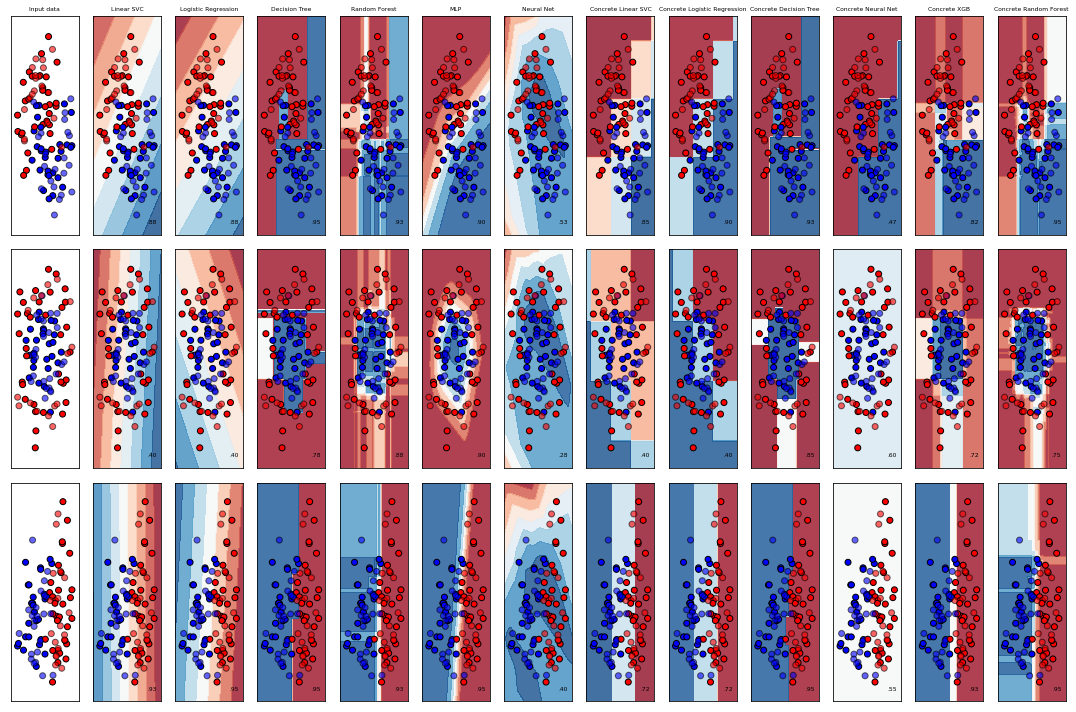

In [3]:
h = 0.02  # Step size in the mesh

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(15, 10))
font_size_text = 6

i = 1

# Iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # Preprocess dataset, split into training and test part
    X, y = ds
    X = X.astype(np.float32)
    X = StandardScaler().fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Just plot the dataset first
    cm = plt.cm.RdBu
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifier_list) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data", fontsize=font_size_text)

    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

    # Plot the testing points
    ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k")
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # Iterate over classifiers
    for clf, name in classifier_list:

        ax = plt.subplot(len(datasets), len(classifier_list) + 1, i)

        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)

        # Plot the decision boundary. For that, we will assign a color to each
        # point in the mesh [x_min, x_max]x[y_min, y_max].
        if hasattr(clf, "decision_function"):
            Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])
        else:
            Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]

        # Put the result into a color plot
        Z = Z.reshape(xx.shape)
        ax.contourf(xx, yy, Z, cmap=cm, alpha=0.8)

        # Plot the training points
        ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")

        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max())
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name, fontsize=font_size_text)
        ax.text(
            xx.max() - 0.3,
            yy.min() + 0.3,
            f"{score:.2f}".lstrip("0"),
            size=font_size_text,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()